In [1]:
import pandas as pd
import numpy as np
import pickle

import xgboost as xg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
data = pd.read_csv('../data/chi_df_cleaned.csv')
data.head()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,year,month,week,start_time_ep,end_time_ep,weather_timestamp_ep,accident_duration,side_R,side_nan,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_VAR,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,weather_condition_nan,sunrise_sunset_Night,sunrise_sunset_nan,civil_twilight_Night,civil_twilight_nan,nautical_twilight_Night,nautical_twilight_nan,astronomical_twilight_Night,astronomical_twilight_nan,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,day_nan,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
0,2,42.305960,-87.960150,42.306916,-87.960918,0.077,37.0,31.0,79.0,29.59,10.0,8.1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016,11,48,1.480517e+09,1.480539e+09,1.480518e+09,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,42.175870,-88.135770,42.174620,-88.135794,0.086,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016,11,48,1.480518e+09,1.480540e+09,1.480518e+09,21600.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,42.175897,-88.135769,42.174612,-88.135794,0.089,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016,11,48,1.480519e+09,1.480541e+09,1.480518e+09,22524.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
X = data.drop(['severity'], axis=1)
y = data['severity']

In [5]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
X_train.head()

,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,year,month,week,start_time_ep,end_time_ep,weather_timestamp_ep,accident_duration,side_R,side_nan,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_VAR,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,weather_condition_nan,sunrise_sunset_Night,sunrise_sunset_nan,civil_twilight_Night,civil_twilight_nan,nautical_twilight_Night,nautical_twilight_nan,astronomical_twilight_Night,astronomical_twilight_nan,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,day_nan,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
781,42.25602,-88.15199,42.26149,-88.15439,0.397,18.0,9.8,88.0,29.85,0.8,5.800000,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,12,50,1.481913e+09,1.481935e+09,1.481913e+09,21600.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
17045,41.57765,-87.56348,41.57765,-87.56348,0.000,91.0,91.0,38.0,29.17,10.0,10.003125,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,6,22,1.591119e+09,1.591121e+09,1.591119e+09,1800.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25455,41.98323,-87.81810,41.98254,-87.81517,0.158,28.0,19.0,47.0,29.52,10.0,9.000000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,11,44,1.573246e+09,1.573248e+09,1.573246e+09,1728.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [7]:
X_test.head()

,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,year,month,week,start_time_ep,end_time_ep,weather_timestamp_ep,accident_duration,side_R,side_nan,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_VAR,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,weather_condition_nan,sunrise_sunset_Night,sunrise_sunset_nan,civil_twilight_Night,civil_twilight_nan,nautical_twilight_Night,nautical_twilight_nan,astronomical_twilight_Night,astronomical_twilight_nan,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,day_nan,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
32814,41.929409,-88.022481,41.929409,-88.022481,0.000,60.1,60.1,42.0,29.94,10.0,6.9,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2018,4,14,1.523451e+09,1.523452e+09,1.523451e+09,1800.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
19315,41.699890,-88.030280,41.699890,-88.030280,0.000,85.0,85.0,57.0,29.07,10.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,2020,6,25,1.593268e+09,1.593271e+09,1.593268e+09,2700.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26711,41.867580,-87.620400,41.867580,-87.620400,0.000,33.1,28.7,100.0,29.93,1.2,4.6,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019,2,5,1.549413e+09,1.549415e+09,1.549414e+09,1784.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [8]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (30730, 145)
y_train shape: (30730,)
X_test shape: (10244, 145)
y_test shape: (10244,)


In [9]:
def print_scores(model_name, model, xtrain, ytrain, xtest, ytest, preds):
    print(f'{model_name} Accuracy Scores')
    print('-'*53)
    print(f'{model_name} Training:', model.score(xtrain,ytrain))
    print(f'{model_name} Testing:', model.score(xtest,ytest))
    print('-'*53)
    print('Classification Report')
    print('-'*53)
    print(classification_report(y_test, preds, zero_division=0))
    plot_confusion_matrix(model, xtest, ytest);

In [10]:
def compare_preds(true, preds):
    compare = pd.DataFrame([true.value_counts(normalize=True).sort_index().index, true.value_counts(normalize=True).sort_index().values, pd.DataFrame(preds).value_counts(normalize=True).sort_index().values]).T
    return pd.DataFrame(compare).rename(columns={0:'Severity',1:'True Label Distribution',2:'Predicted Label Distribution'}).set_index('Severity')

[20:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Accuracy Scores
-----------------------------------------------------
XGBoost Training: 0.9107386918320859
XGBoost Testing: 0.8482038266302225
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.21      0.30        62
           2       0.84      0.87      0.86      4226
           3       0.86      0.89      0.88      5200
           4       0.77      0.45      0.57       756

    accuracy                           0.85     10244
   macro avg       0.74      0.61      0.65     10244
weighted avg       0.84      0.85      0.84     10244



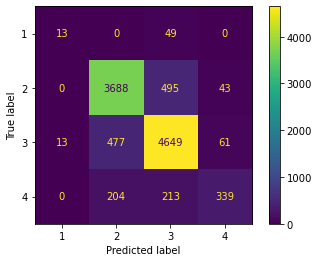

In [11]:
xg_model = xg.sklearn.XGBClassifier()
xg_model.fit(X_train,y_train)
xg_preds = xg_model.predict(X_test)
print_scores('XGBoost', xg_model, X_train, y_train, X_test, y_test, xg_preds)

In [12]:
compare_preds(y,xg_preds)

,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.002538
2.0,0.412481,0.426494
3.0,0.507615,0.527724
4.0,0.073827,0.043245


Decision Tree Accuracy Scores
-----------------------------------------------------
Decision Tree Training: 0.798991213797592
Decision Tree Testing: 0.7883639203436158
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.78      0.82      0.80      4226
           3       0.80      0.88      0.83      5200
           4       0.55      0.06      0.11       756

    accuracy                           0.79     10244
   macro avg       0.53      0.44      0.44     10244
weighted avg       0.77      0.79      0.76     10244



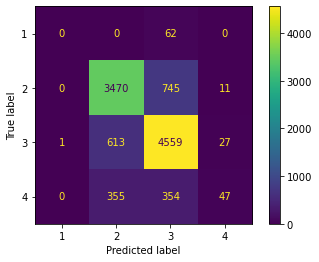

In [13]:
# decision tree model with just a few hyperparameters
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5)
tree.fit(X_train,y_train)
tree_preds = tree.predict(X_test)
print_scores('Decision Tree', tree, X_train, y_train, X_test, y_test, tree_preds);

In [14]:
tree_coefs = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns=['feature','coefficient'])
tree_coefs[tree_coefs['coefficient'] > 0][:15].sort_values(by='coefficient', ascending=False)

,feature,coefficient
4,distance(mi),0.051771
27,week,0.015255
2,end_lat,0.011818
1,start_lng,0.009776
3,end_lng,0.008645
23,traffic_signal,0.005521
8,pressure(in),0.004807
6,wind_chill(f),0.002856
0,start_lat,0.002687
5,temperature(f),0.001639


Random Forrest Accuracy Scores
-----------------------------------------------------
Random Forrest Training: 0.8023429873088187
Random Forrest Testing: 0.7886567746973838
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.80      0.80      0.80      4226
           3       0.78      0.90      0.84      5200
           4       1.00      0.01      0.03       756

    accuracy                           0.79     10244
   macro avg       0.65      0.43      0.42     10244
weighted avg       0.80      0.79      0.76     10244



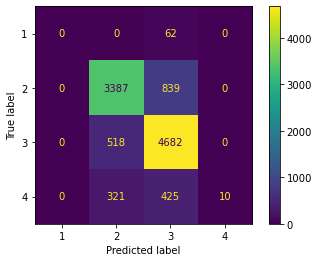

In [15]:
forrest = RandomForestClassifier(max_depth=10)
forrest.fit(X_train,y_train)
forrest_preds = forrest.predict(X_test)
print_scores('Random Forrest', forrest, X_train, y_train, X_test, y_test, forrest_preds);

BAG Classifier Accuracy Scores
-----------------------------------------------------
BAG Classifier Training: 0.9906605922551253
BAG Classifier Testing: 0.831901600937134
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.48      0.18      0.26        62
           2       0.82      0.87      0.84      4226
           3       0.85      0.87      0.86      5200
           4       0.77      0.42      0.54       756

    accuracy                           0.83     10244
   macro avg       0.73      0.58      0.63     10244
weighted avg       0.83      0.83      0.83     10244



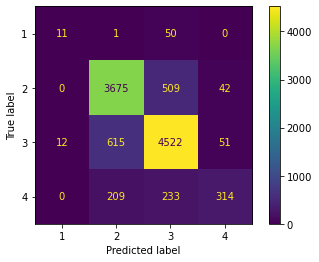

In [16]:
bag = BaggingClassifier(bootstrap_features=True)
bag.fit(X_train,y_train)
bag_preds = bag.predict(X_test)
print_scores('BAG Classifier', bag, X_train, y_train, X_test, y_test, bag_preds);

In [17]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Scaled Accuracy Scores
-----------------------------------------------------
XGBoost Scaled Training: 0.40244061178001955
XGBoost Scaled Testing: 0.412827020695041
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.21      0.30        62
           2       0.84      0.88      0.86      4226
           3       0.86      0.89      0.88      5200
           4       0.78      0.44      0.56       756

    accuracy                           0.85     10244
   macro avg       0.75      0.61      0.65     10244
weighte

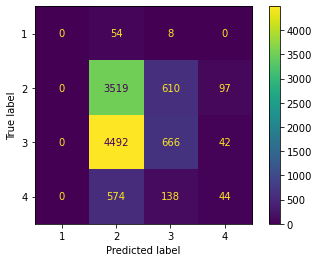

In [18]:
xg_model_sc = xg.sklearn.XGBClassifier()
xg_model_sc.fit(X_train_sc,y_train);
xg_preds_sc = xg_model_sc.predict(X_test_sc)
print_scores('XGBoost Scaled', bag, X_train_sc, y_train, X_test_sc, y_test, xg_preds_sc);

Decision Tree Scaled Accuracy Scores
-----------------------------------------------------
Decision Tree Scaled Training: 0.7990237552879922
Decision Tree Scaled Testing: 0.7880710659898477
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.78      0.82      0.80      4226
           3       0.80      0.88      0.83      5200
           4       0.57      0.06      0.11       756

    accuracy                           0.79     10244
   macro avg       0.54      0.44      0.44     10244
weighted avg       0.77      0.79      0.76     10244



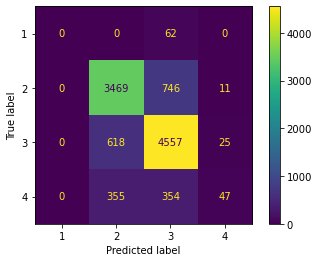

In [19]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5)
tree.fit(X_train_sc,y_train)
tree_preds_sc = tree.predict(X_test_sc)
print_scores('Decision Tree Scaled', tree, X_train_sc, y_train, X_test_sc, y_test, tree_preds_sc);

Random Forrest Scaled Accuracy Scores
-----------------------------------------------------
Random Forrest Scaled Training: 0.7990237552879922
Random Forrest Scaled Testing: 0.7880710659898477
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.81      0.80      0.80      4226
           3       0.78      0.90      0.84      5200
           4       0.91      0.01      0.03       756

    accuracy                           0.79     10244
   macro avg       0.62      0.43      0.42     10244
weighted avg       0.79      0.79      0.76     10244



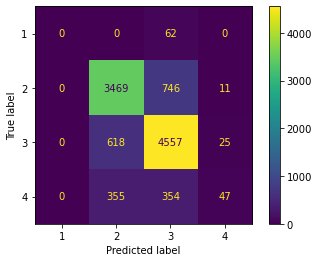

In [20]:
forrest = RandomForestClassifier(max_depth=10)
forrest.fit(X_train_sc,y_train)
forrest_preds_sc = forrest.predict(X_test_sc)
print_scores('Random Forrest Scaled', tree, X_train_sc, y_train, X_test_sc, y_test, forrest_preds_sc);

BAG Classifier Scaled Accuracy Scores
-----------------------------------------------------
BAG Classifier Scaled Training: 0.990628050764725
BAG Classifier Scaled Testing: 0.8355134713002733
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.56      0.08      0.14        62
           2       0.83      0.87      0.85      4226
           3       0.85      0.88      0.86      5200
           4       0.81      0.40      0.54       756

    accuracy                           0.84     10244
   macro avg       0.76      0.56      0.60     10244
weighted avg       0.83      0.84      0.83     10244



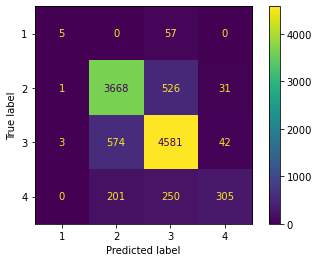

In [21]:
bag = BaggingClassifier(bootstrap_features=True)
bag.fit(X_train_sc,y_train)
bag_preds_sc = bag.predict(X_test_sc)
print_scores('BAG Classifier Scaled', bag, X_train_sc, y_train, X_test_sc, y_test, bag_preds_sc);

In [22]:
y_train_cat = utils.to_categorical(y_train-1, 4)
y_test_cat = utils.to_categorical(y_test-1, 4)

In [23]:
y_test_cat

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [24]:
nn = Sequential()

nn.add(
    Dense(
        128,
        activation = 'relu'
    )
)

nn.add(Dropout(.4))

nn.add(
    Dense(
        64,
        activation = 'relu'
    )
)

nn.add(Dropout(.3))

nn.add(
    Dense(
        32,
        activation = 'relu'
    )
)

nn.add(Dropout(.2))

nn.add(
    Dense(
        16,
        activation = 'relu'
    )
)

nn.add(Dropout(.1))

nn.add(
    Dense(
        8,
        activation = 'relu'
    )
)

nn.add(
    Dense(
        4,
        activation = 'softmax'
    )
)

nn.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [25]:
history = nn.fit(
    X_train_sc, 
    y_train_cat,
    validation_data=(X_test_sc, y_test_cat),
    epochs = 512,
    verbose = 0
)

In [26]:
max(history.history['accuracy']),max(history.history['val_accuracy'])

(0.8498535752296448, 0.8118898868560791)

In [27]:
nn.save('./models/neural_net')

INFO:tensorflow:Assets written to: ./models/neural_net\assets
